In [1]:
import numpy as np
import pandas as pd
import sklearn
import ot
import matplotlib.pyplot as plt



In [2]:
def compute_rmse(predictions, test_matrix):
  masked = np.ma.array(test_matrix, mask=np.isnan(test_matrix))
  diff = np.ma.subtract(predictions, masked)
  squared = np.ma.power(diff, 2)
  return np.ma.sqrt(np.ma.mean(squared))


In [3]:
ratings_train = np.load('../datasets/ratings_train.npy')
ratings_test = np.load('../datasets/ratings_test.npy')
m,n = ratings_train.shape
data = np.nan_to_num(ratings_train)
data_test = np.nan_to_num(ratings_test)


In [11]:
from sklearn.decomposition import NMF
import scipy.sparse as sps
from scipy.spatial.distance import pdist, squareform

csr_ratings_train = sps.csr_matrix(np.nan_to_num(ratings_train), shape=(610, 4980))
csr_ratings_train.eliminate_zeros()

nmf = NMF(n_components=10, init='nndsvd', random_state=0, max_iter=1000)
W = nmf.fit_transform(csr_ratings_train)
H = nmf.components_
flattened_array = np.unique(H.flatten())
sorted_unique = np.sort(flattened_array)
second_min = sorted_unique[1]
threshold = second_min/2
H[H < threshold] = threshold
flattened_array = np.unique(W.flatten())
sorted_unique = np.sort(flattened_array)
second_min = sorted_unique[1]
threshold = second_min/2
W[W < threshold] = threshold


from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA

pca = PCA(n_components=10)

user_dist = pdist(data, metric='jaccard')
user_sim_matrix = squareform(user_dist)
W = pca.fit_transform(user_sim_matrix)

movie_dist = pdist(data.T, metric='jaccard')
movie_sim_matrix = squareform(movie_dist)
H = pca.fit_transform(movie_sim_matrix)


In [16]:
from Matcher import Matcher, model_parameters,train_parameters

train_pi_sample = ratings_train / data.sum()
test_pi_sample = ratings_test/data_test.sum()
data_pi_sample = data / data.sum()

# RiOT
model = Matcher(train_pi_sample, W.T, H.T, r=5)
lam = 1
model_param = model_parameters(A0=np.eye(10, 10),
                                        gamma=0.2,
                                        const=1,
                                        degree=2,
                                        lam=lam,
                                        lambda_mu=1,
                                        lambda_nu=1,
                                        delta=0.005)
train_param = train_parameters(max_outer_iteration=1,
                                        max_inner_iteration=10,
                                        learning_rate=0.01)
model.riot(model_param, train_param)
# test_r, test_c = data_pi_sample.sum(axis=1), data_pi_sample.sum(axis=0)
# pred_pi = ot.rot(model.C, test_r, test_c, lam)[0]

# print(compute_rmse(pred_pi,test_pi_sample))


In [21]:
model.C.max()


3.0102333160984625

In [19]:
data_pi_sample = data / data.sum()
test_r, test_c = data_pi_sample.sum(axis=1), data_pi_sample.sum(axis=0)
pred_pi = ot.rot(model.C, test_r, test_c, lam)[0]


In [25]:
np.unique(pred_pi, return_counts=True)


(array([1.94016941e-10, 1.94071678e-10, 1.94086521e-10, ...,
        1.59811520e-04, 1.85441781e-04, 1.89047734e-04]),
 array([1, 1, 2, ..., 1, 1, 1]))

In [23]:
def transform_to_integers(matrix):
    num_intervals = 10
    min_value = matrix.min()
    max_value = matrix.max()

    # Calculate the interval width
    interval_width = (max_value - min_value) / num_intervals

    # Map the values to integers between 1 and 10
    transformed_matrix = ((matrix - min_value) / interval_width).clip(0, num_intervals).astype(int) / 2

    return transformed_matrix


In [37]:
print(compute_rmse(transform_to_integers(model.C), ratings_train))


2.726753705645478


In [28]:
transform_to_integers(model.C)


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [26]:
np.unique(np.around(np.clip(model.C, a_min=0, a_max=5), 0), return_counts=True)


(array([1., 2., 3., 4., 5.]),
 array([3029587,    5999,    1751,     424,      39]))

In [40]:
model.C.argmax()


3033230

In [41]:
pred_pi.flatten()[3033230]


6.791664318245063e-07

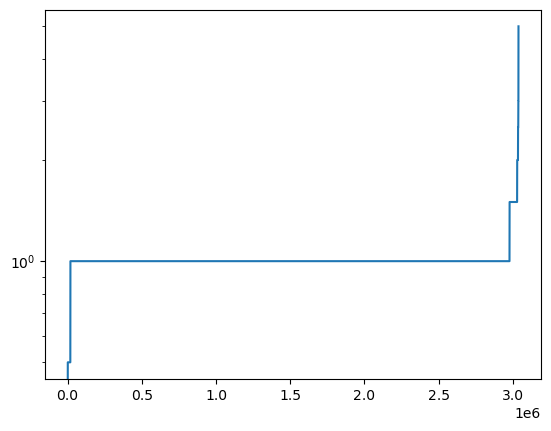

In [29]:
flattened_pred_pi = transform_to_integers(model.C).flatten()
flattened_pred_pi.sort()
fig, ax = plt.subplots()
ax.set_yscale('log')
plt.plot(range(len(flattened_pred_pi)), flattened_pred_pi,)


In [34]:
31598/(610*4980)


0.01040160642570281

In [33]:
np.count_nonzero(~np.isnan(ratings_train))


31598

In [39]:
flattened_pred_pi[-1]


0.00018588545871522195

In [43]:
flattened_pred_pi[-1] - flattened_pred_pi[0]


0.00018588526471437244

In [5]:
from Matcher import Matcher, model_parameters,train_parameters
def run_riot_matcher():
  train_pi_sample = data / data.sum()
  test_pi_sample = data_test/data_test.sum()
  # RiOT
  model = Matcher(train_pi_sample, W.T, H, r=5)
  lam = 1
  model_param = model_parameters(A0=np.eye(10, 10),
                                          gamma=0.2,
                                          const=1,
                                          degree=2,
                                          lam=lam,
                                          lambda_mu=1,
                                          lambda_nu=1,
                                          delta=0.005)
  train_param = train_parameters(max_outer_iteration=1,
                                          max_inner_iteration=1,
                                          learning_rate=0.01)
  model.riot(model_param, train_param)
  test_r, test_c = train_pi_sample.sum(axis=1), train_pi_sample.sum(axis=0)
  return ot.rot(model.C, test_r, test_c, lam)[0]


In [6]:
run_riot_matcher()


KeyboardInterrupt: 